In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import pickle as pkl

%load_ext autoreload
%autoreload 2
from utils import *
from layers import *
from cnn import *
from cifar10 import *

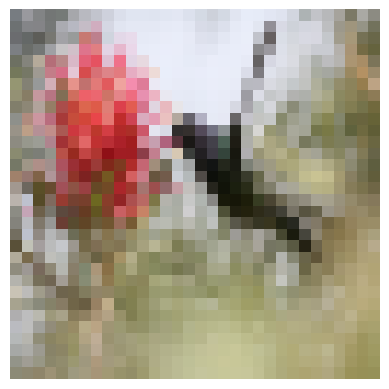

In [7]:
showimg(getunsupervised(20000))

In [ ]:
showimg(getimg(1))
getlabel(1)

In [3]:

def batchgen(bsize=64, start=500):
    ep = 0
    while True:
        inds = np.random.permutation(range(start, N))
        minibatches = [ inds[k*bsize:(k+1)*bsize] for k in range(len(inds)//bsize) ]
        for mb in minibatches:
            xs = []
            ys = []
            for i in mb:
                xs.append(getimg(i))
                ys.append(getlabel(i))
            yield np.array(xs), np.array(ys)
        print(f'========== EPOCH {ep} COMPLETED ==========')
        ep += 1

In [10]:
bg = batchgen()
xs, ys = next(bg)
xs.shape

(64, 32, 32, 3)

In [24]:
def valloss():
    xs = np.array([getimg(i) for i in range(500)])
    yt = np.array([getlabel(i) for i in range(500)])
    xs, yt = np2t(xs, yt)
    yt = yt.long()
    yp = net(xs)
    loss = F.nll_loss(F.log_softmax(yp, dim=1), yt).item()
    yp, yt = t2np(yp, yt)
    yp = yp.argmax(-1)
    acc = np.mean(yp==yt)
    return loss, acc
    
def loss():
    xs, yt = next(bg)
    xs, yt = np2t(xs, yt)
    yt = yt.long()
    yp = net(xs)
    return F.nll_loss(F.log_softmax(yp, dim=1), yt) - torch.mean(F.log_softmax(yp, dim=1)) / 10
   ''' 
def loss():
    'Loss for destillation'
    xs, yt = next(bg)
    xs, yt = np2t(xs, yt)
    yt = yt.long()
    with torch.no_grad():
        yp1 = net1(xs)
        yp2 = net2(xs)
        yp3 = net3(xs)
        yp_teacher = (yp1+yp2+yp3)/3
    yp = net(xs)
    tau = 5
    return torch.mean(-F.log_softmax(yp/tau) * F.softmax(yp_teacher/tau)) + \
           F.nll_loss(F.log_softmax(yp, dim=1), yt) - torch.mean(F.log_softmax(yp, dim=1)) / 10
'''
loss()

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 19)

In [25]:
net = Net(n=16).cuda()
from torch_optimizer import Lookahead, Yogi
net.optim = Lookahead(Yogi(net.parameters(), lr=3e-3))
net.iters = 0
net.losses = []
net.vlosses = []
net.vaccs = []
bg = batchgen()

from torchsummary import summary
#summary(net, (32, 32, 3))

vmin = 99999

  0%|          | 0/999999 [00:00<?, ?it/s]

C:\Users\Ma Ha\AppData\Local\Temp\ipykernel_28612\4204948306.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.mean(-F.log_softmax(yp/tau) * F.softmax(yp_teacher/tau)) + \
C:\Users\Ma Ha\AppData\Local\Temp\ipykernel_28612\4204948306.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.mean(-F.log_softmax(yp/tau) * F.softmax(yp_teacher/tau)) + \


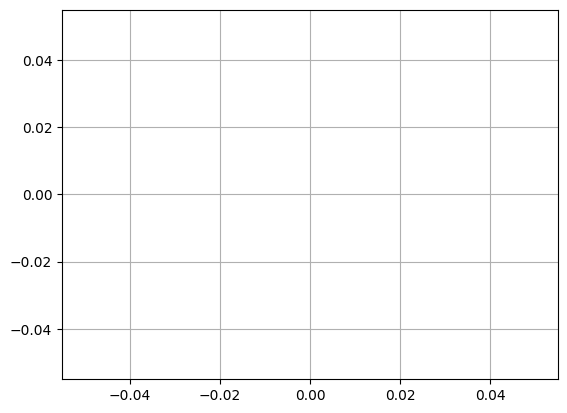

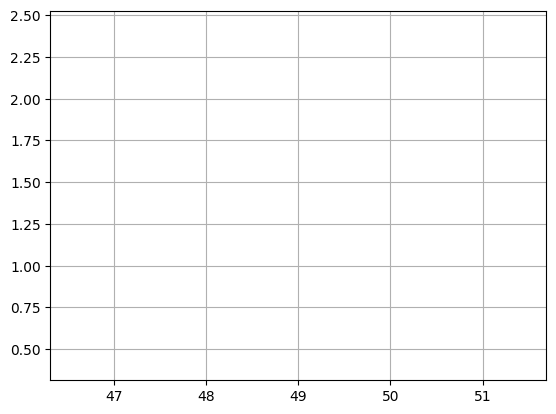

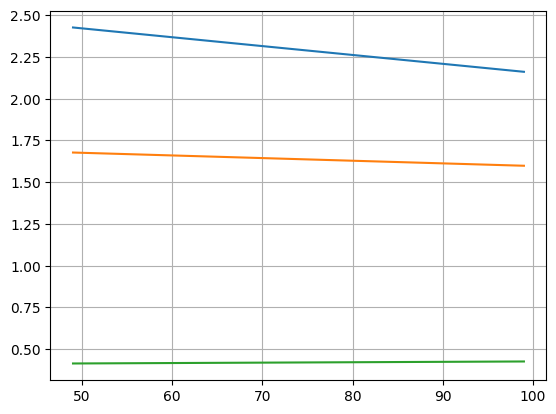

========== EPOCH 0 COMPLETED ==========


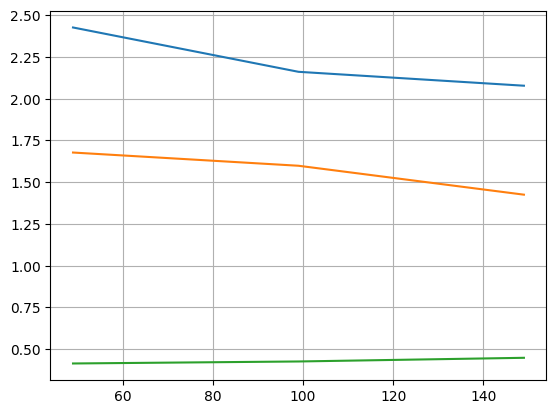

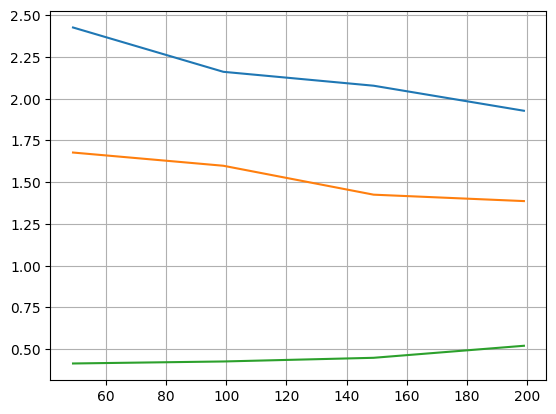

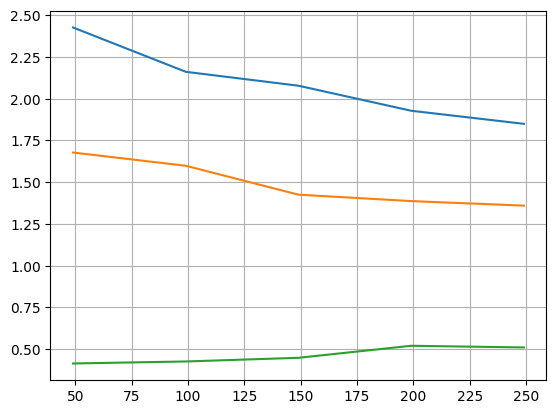

========== EPOCH 1 COMPLETED ==========


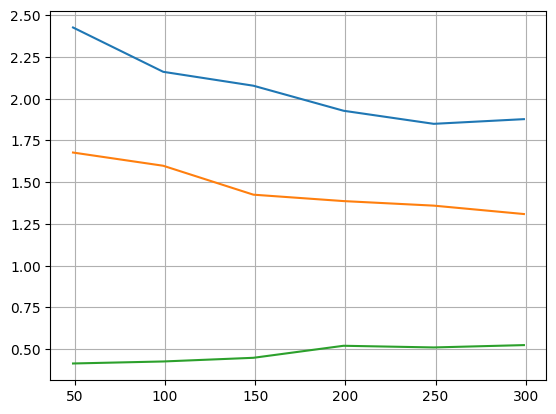

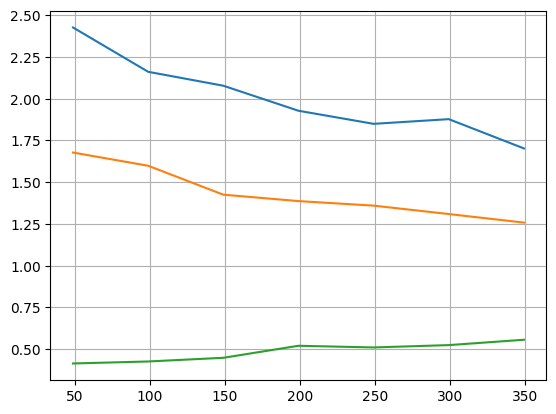

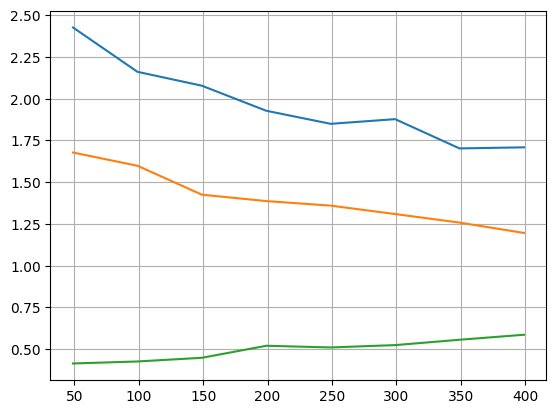

========== EPOCH 2 COMPLETED ==========


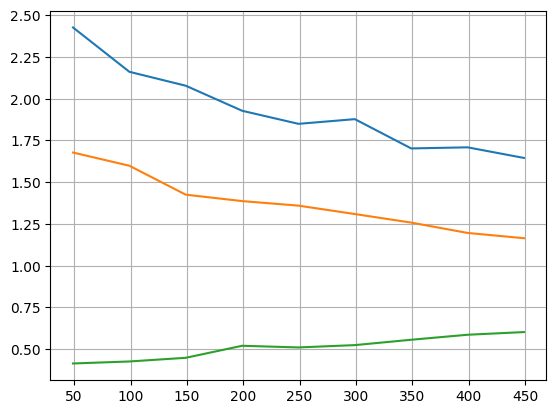

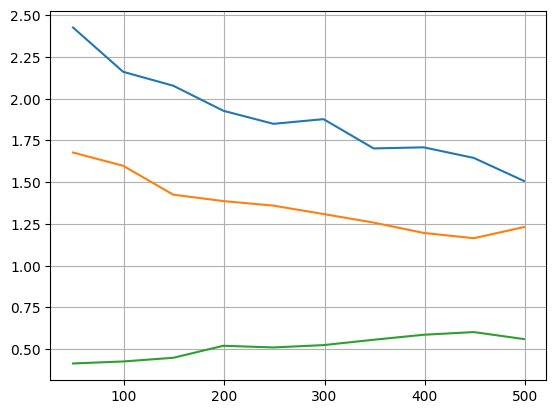

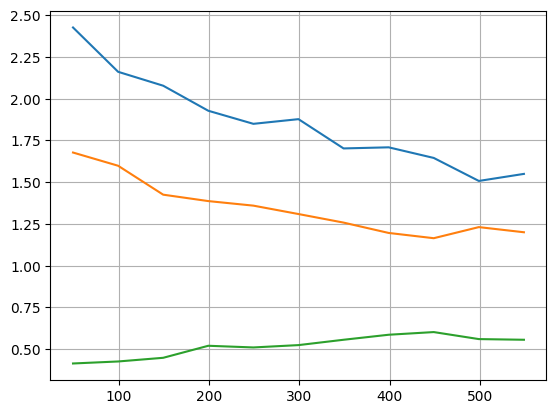

========== EPOCH 3 COMPLETED ==========


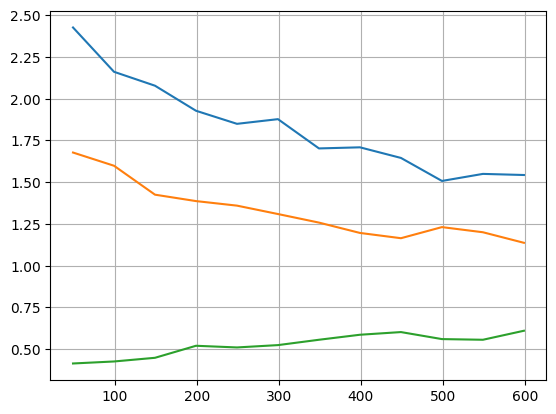

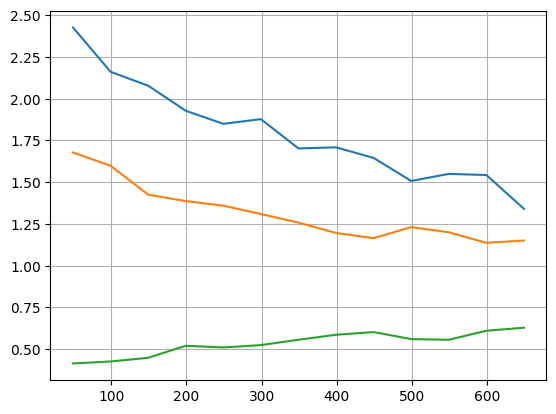

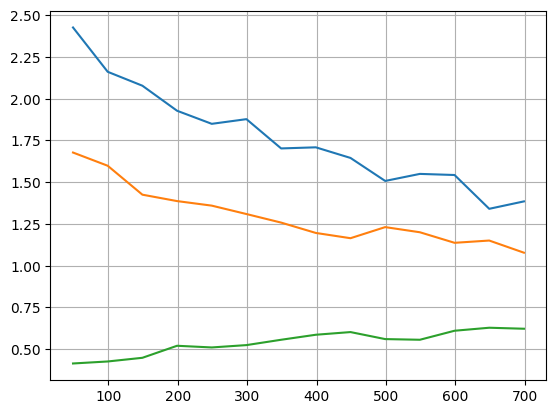

========== EPOCH 4 COMPLETED ==========


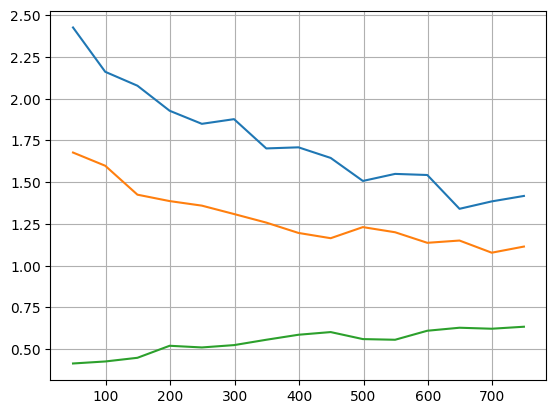

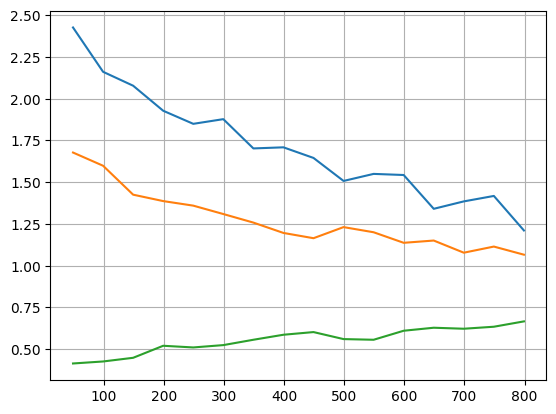

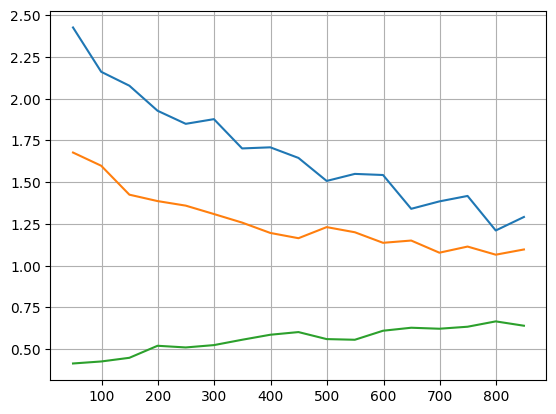

========== EPOCH 5 COMPLETED ==========


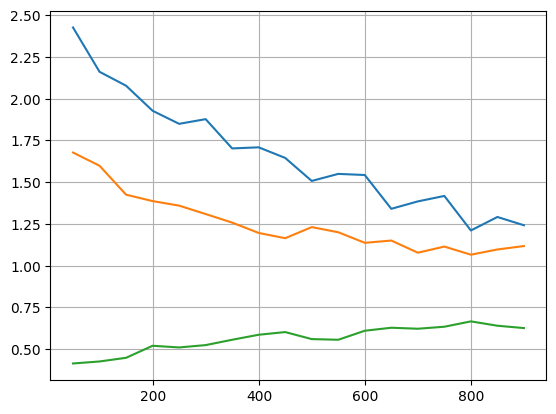

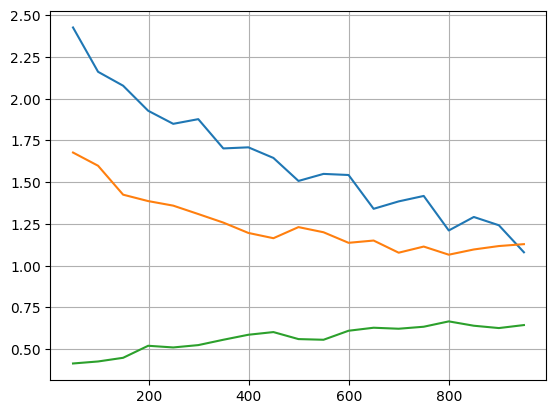

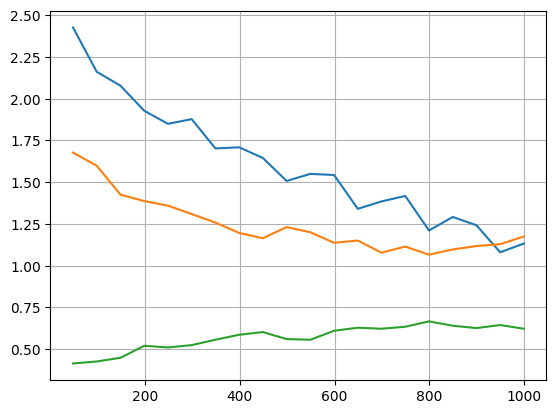

========== EPOCH 6 COMPLETED ==========


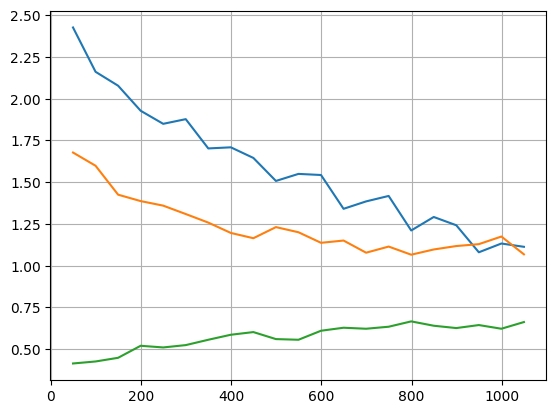

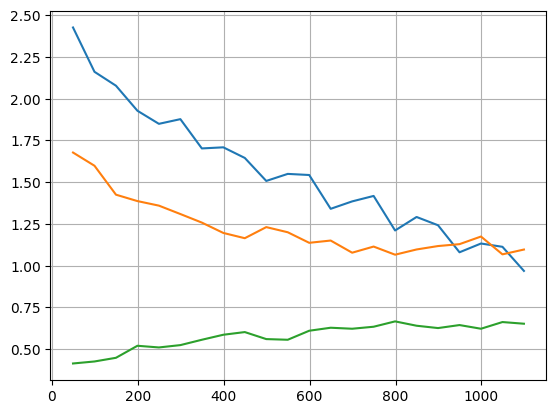

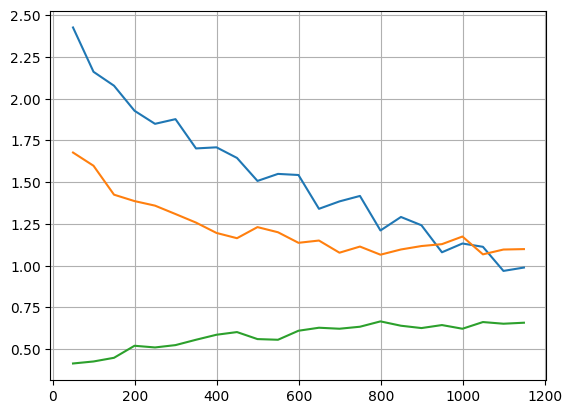

========== EPOCH 7 COMPLETED ==========


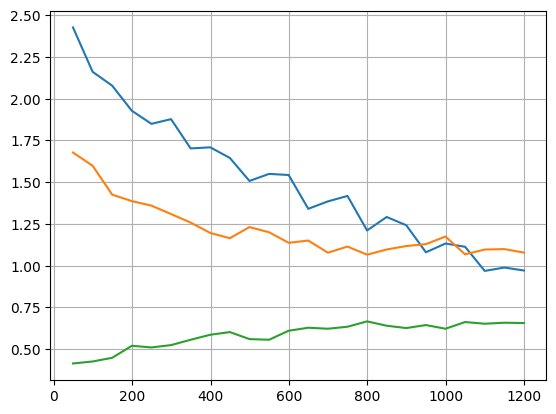

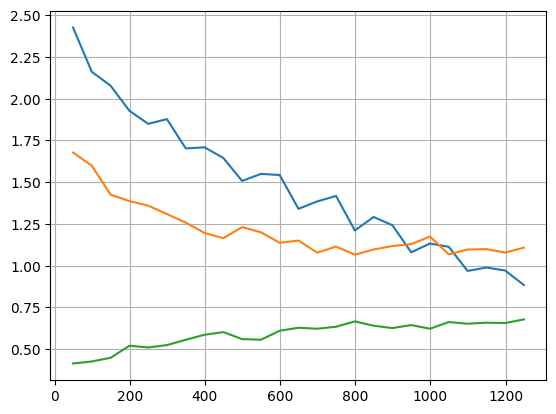

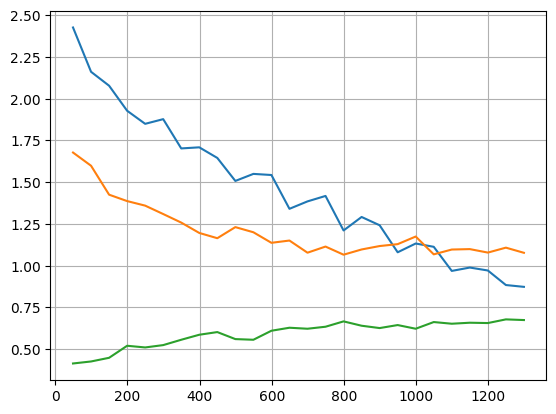

========== EPOCH 8 COMPLETED ==========


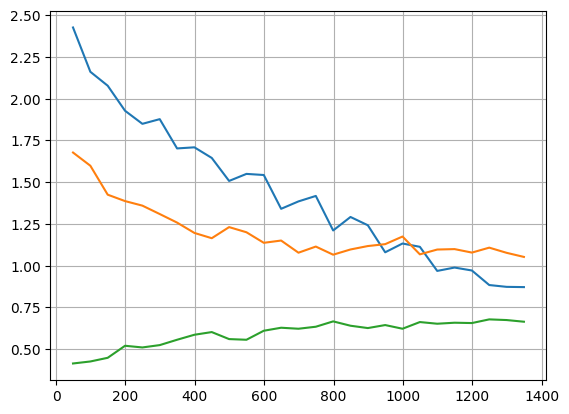

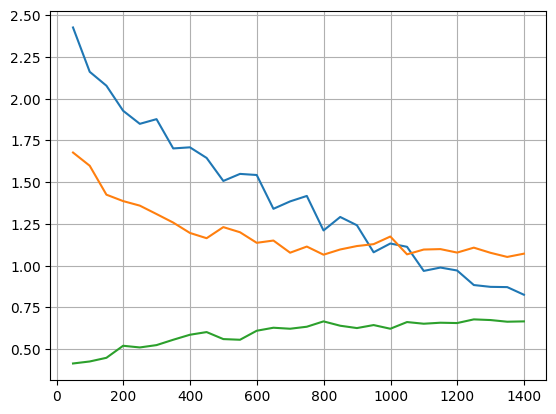

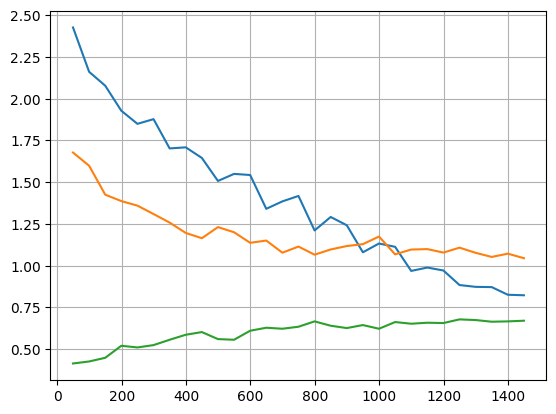

========== EPOCH 9 COMPLETED ==========


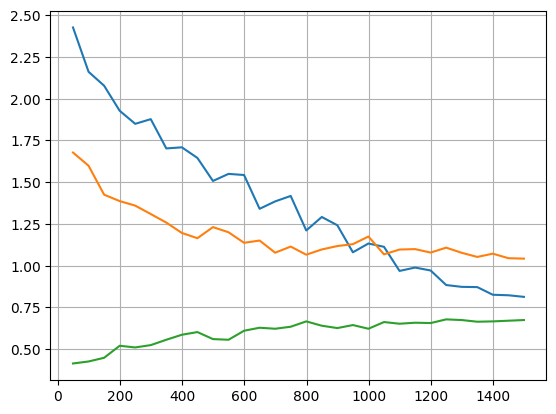

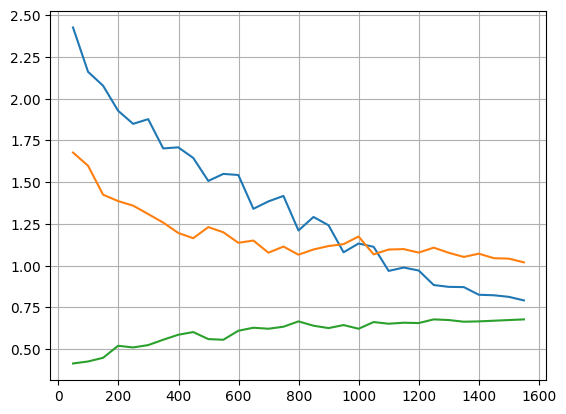

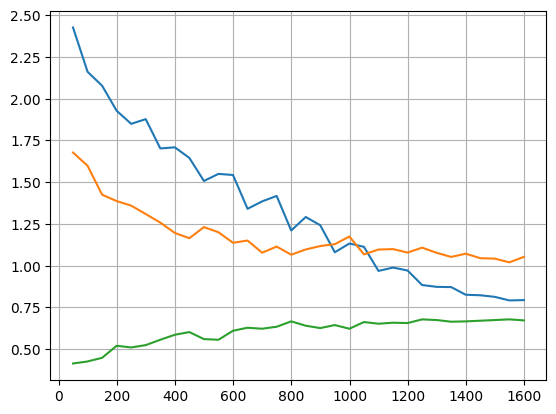

========== EPOCH 10 COMPLETED ==========


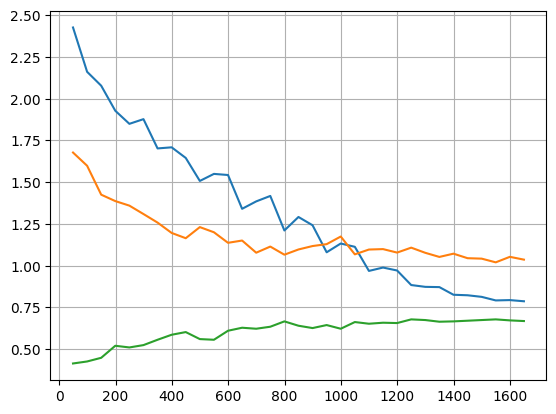

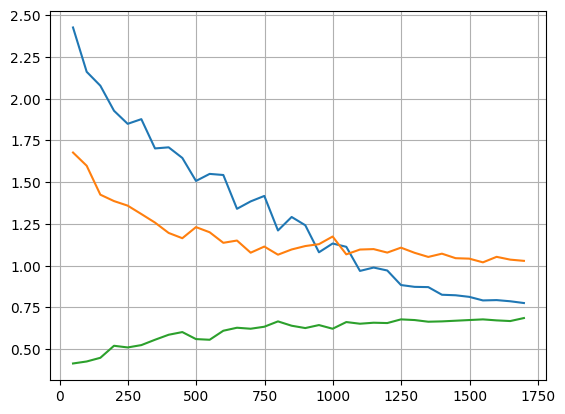

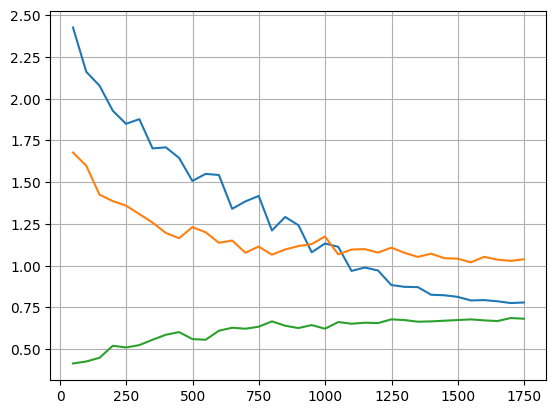

========== EPOCH 11 COMPLETED ==========


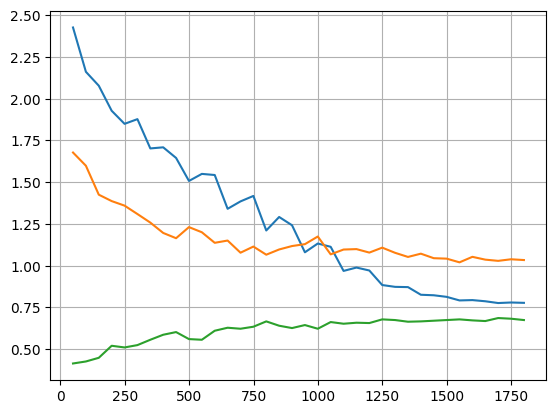

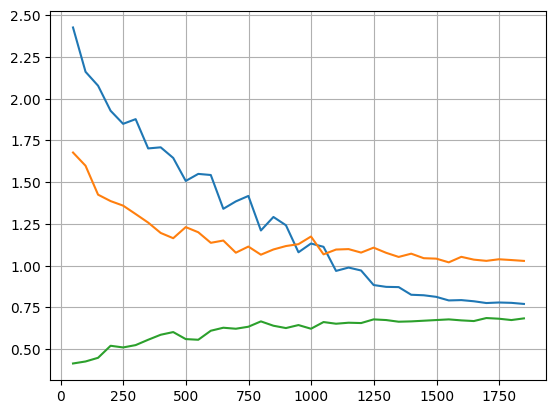

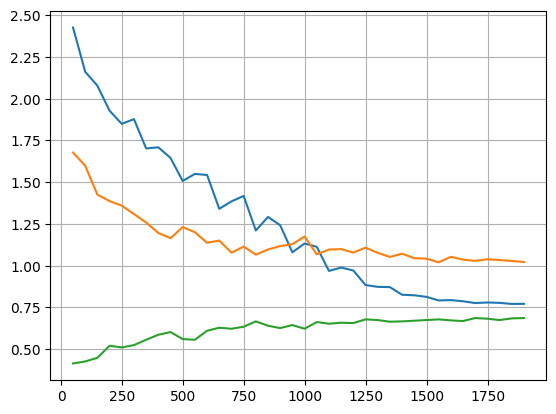

========== EPOCH 12 COMPLETED ==========


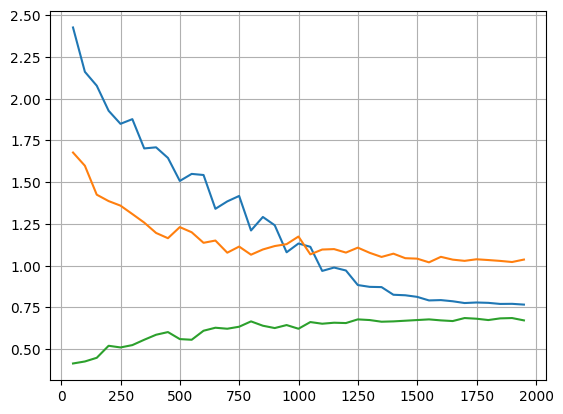

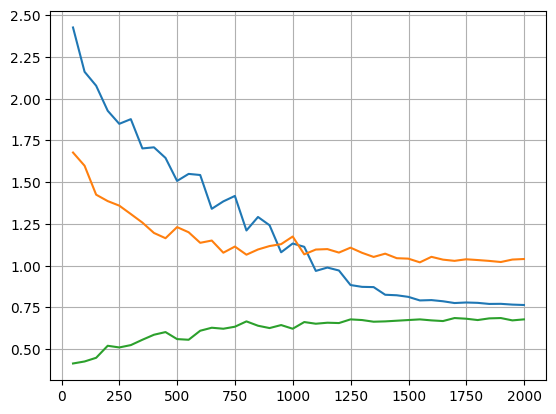

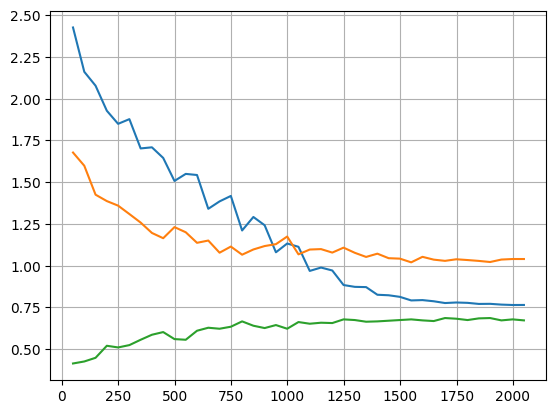

========== EPOCH 13 COMPLETED ==========


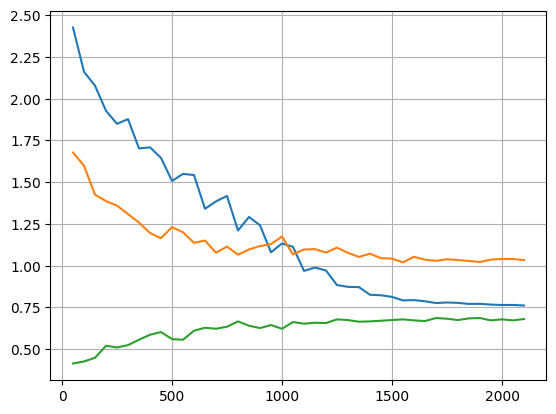

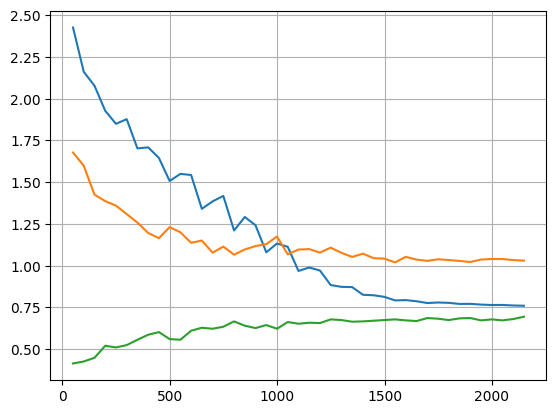

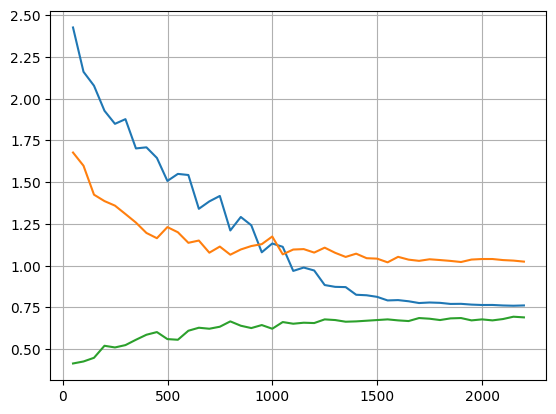

========== EPOCH 14 COMPLETED ==========


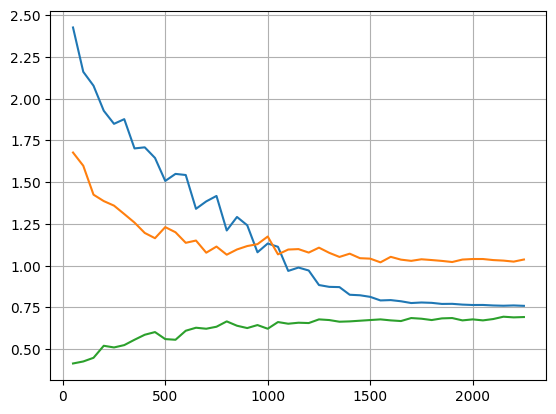

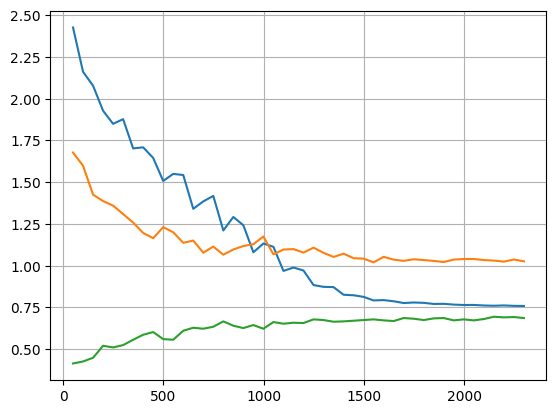

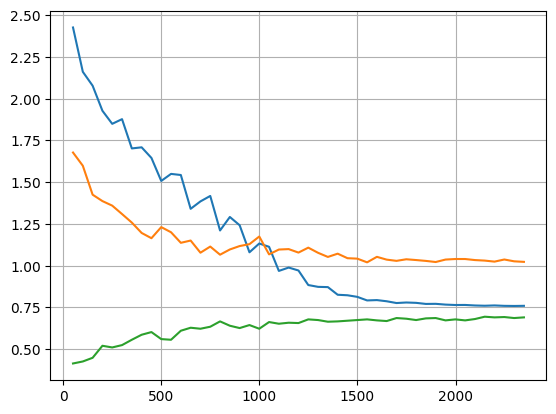

========== EPOCH 15 COMPLETED ==========


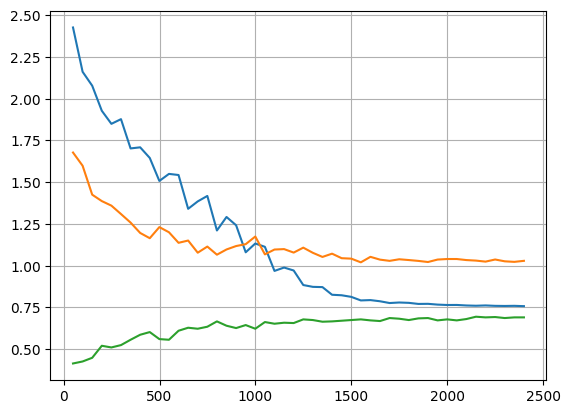

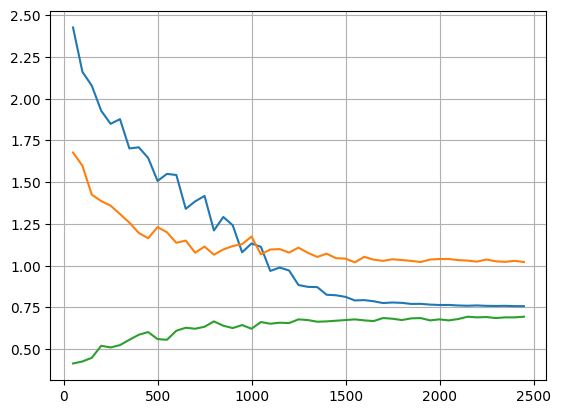

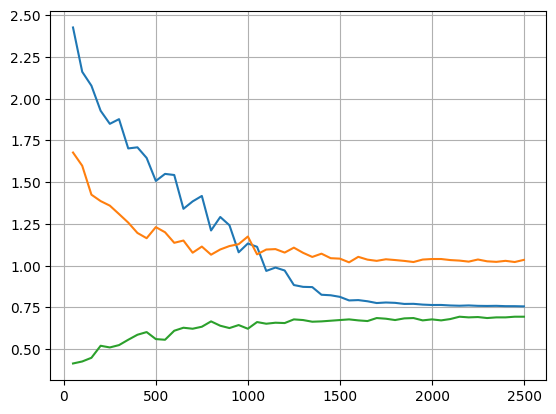

========== EPOCH 16 COMPLETED ==========


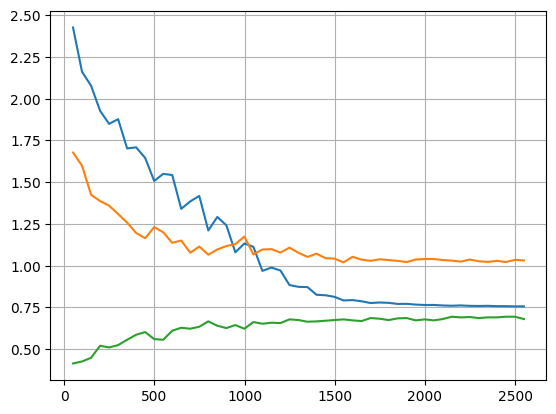

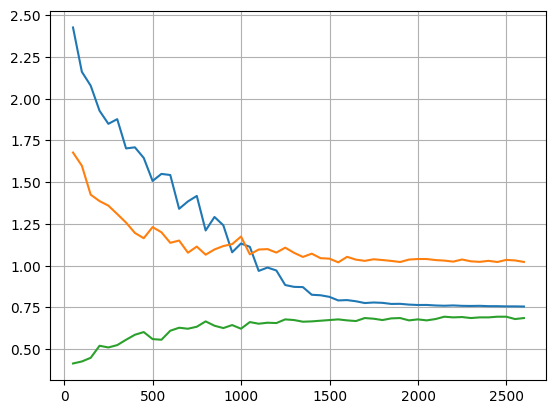

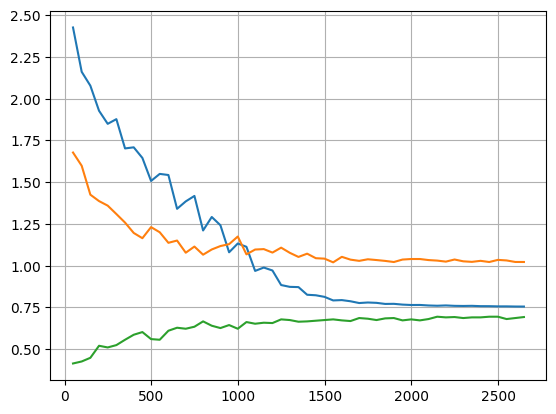

========== EPOCH 17 COMPLETED ==========


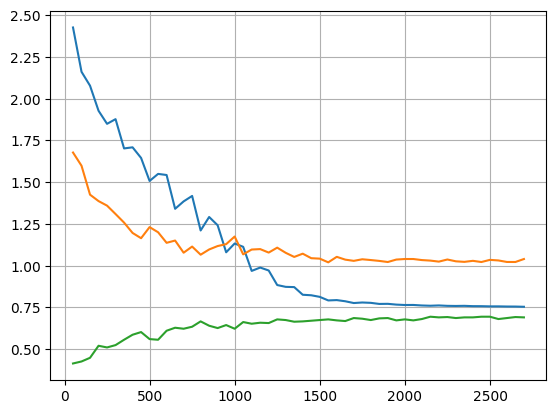

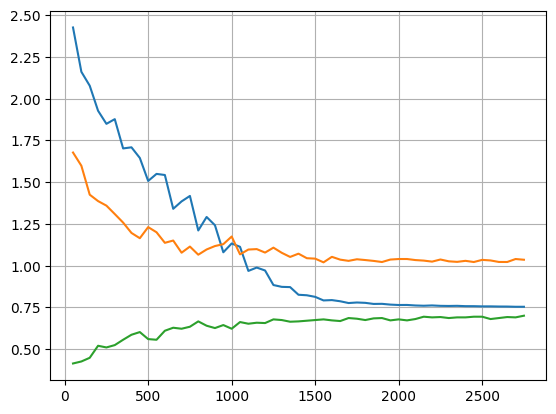

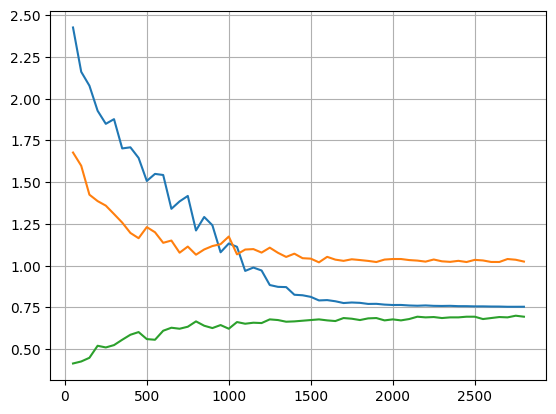

========== EPOCH 18 COMPLETED ==========


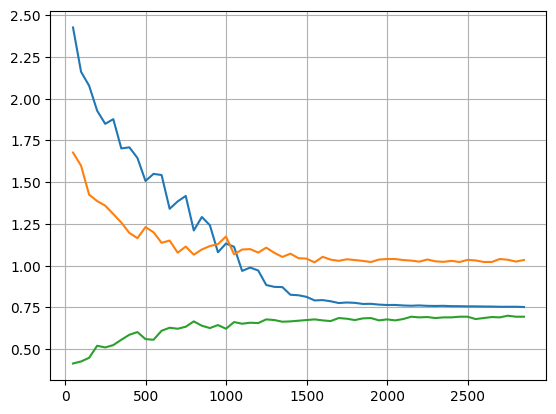

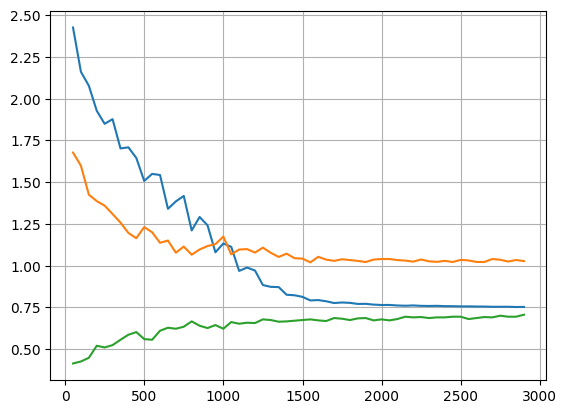

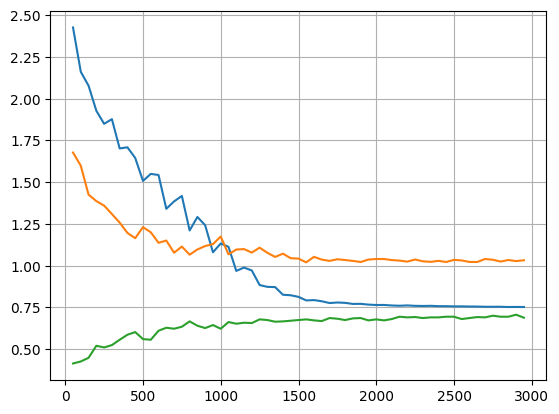

========== EPOCH 19 COMPLETED ==========


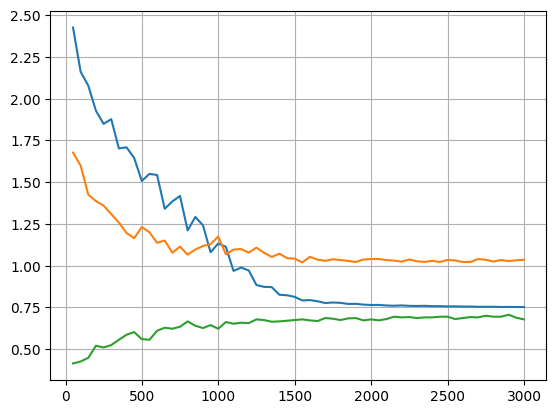

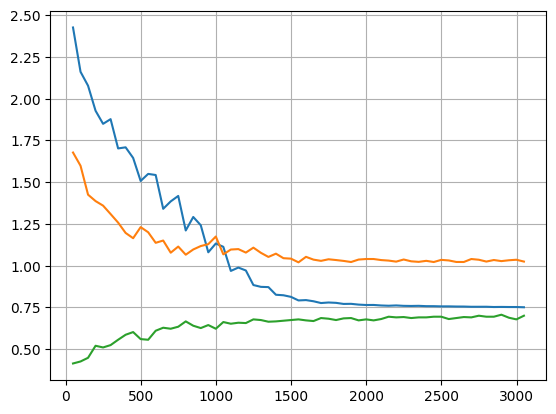

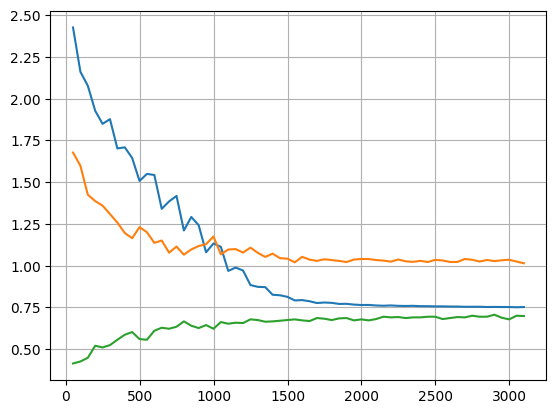

========== EPOCH 20 COMPLETED ==========


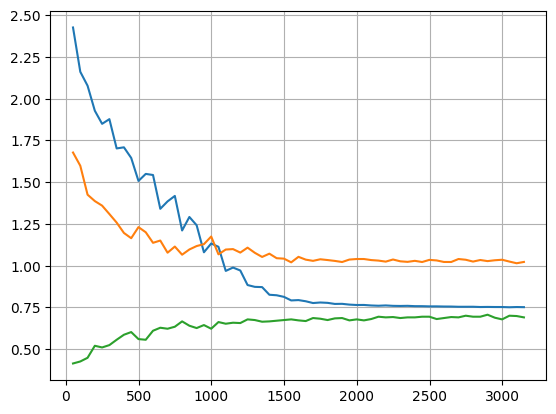

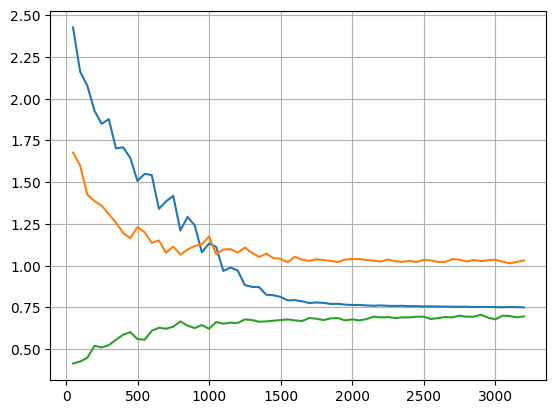

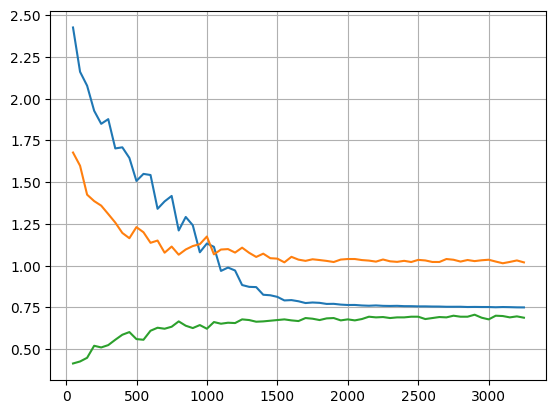

========== EPOCH 21 COMPLETED ==========


KeyboardInterrupt: 

In [26]:
losses = []

for k in trange(999999):
    net.train()
    l = loss()
    l.backward()
    losses.append(l.item())
    net.optim.step()
    net.zero_grad()

    if len(losses) == 50:
        vl, vacc = valloss()
        net.vlosses.append((net.iters, vl))
        net.vaccs.append((net.iters, vacc))
        net.losses.append((net.iters, np.mean(losses)))
        losses = []
        if vl < vmin:
            #torch.save(net.state_dict(), 'cnn3.dat')
            vmin = vl

    if k % 50 == 0:
        plt.plot(*zip(*net.losses))
        plt.plot(*zip(*net.vlosses))
        plt.plot(*zip(*net.vaccs))
        plt.grid()
        plt.show()

    net.iters += 1

In [27]:
net.vaccs

[(49, 0.414),
 (99, 0.426),
 (149, 0.448),
 (199, 0.52),
 (249, 0.51),
 (299, 0.524),
 (349, 0.556),
 (399, 0.586),
 (449, 0.602),
 (499, 0.56),
 (549, 0.556),
 (599, 0.61),
 (649, 0.628),
 (699, 0.622),
 (749, 0.634),
 (799, 0.666),
 (849, 0.64),
 (899, 0.626),
 (949, 0.644),
 (999, 0.622),
 (1049, 0.662),
 (1099, 0.652),
 (1149, 0.658),
 (1199, 0.656),
 (1249, 0.678),
 (1299, 0.674),
 (1349, 0.664),
 (1399, 0.666),
 (1449, 0.67),
 (1499, 0.674),
 (1549, 0.678),
 (1599, 0.672),
 (1649, 0.668),
 (1699, 0.686),
 (1749, 0.682),
 (1799, 0.674),
 (1849, 0.684),
 (1899, 0.686),
 (1949, 0.672),
 (1999, 0.678),
 (2049, 0.672),
 (2099, 0.68),
 (2149, 0.694),
 (2199, 0.69),
 (2249, 0.692),
 (2299, 0.686),
 (2349, 0.69),
 (2399, 0.69),
 (2449, 0.694),
 (2499, 0.694),
 (2549, 0.68),
 (2599, 0.686),
 (2649, 0.692),
 (2699, 0.69),
 (2749, 0.7),
 (2799, 0.694),
 (2849, 0.694),
 (2899, 0.706),
 (2949, 0.688),
 (2999, 0.678),
 (3049, 0.7),
 (3099, 0.698),
 (3149, 0.69),
 (3199, 0.696),
 (3249, 0.688)]

In [5]:
net1 = Net().cuda()
net2 = Net().cuda()
net3 = Net().cuda()
net1.load_state_dict(torch.load('cnn1.dat'))
net2.load_state_dict(torch.load('cnn2.dat'))
net3.load_state_dict(torch.load('cnn3.dat'))

<All keys matched successfully>

In [31]:
from sklearn.manifold import TSNE

xs = np.array([getimg(i) for i in range(500)])
yt = np.array([getlabel(i) for i in range(500)])
xs = np2t(xs)
yp = net(xs)

X = t2np(net.prelast)
X_embedded = TSNE(n_components=2).fit_transform(X)

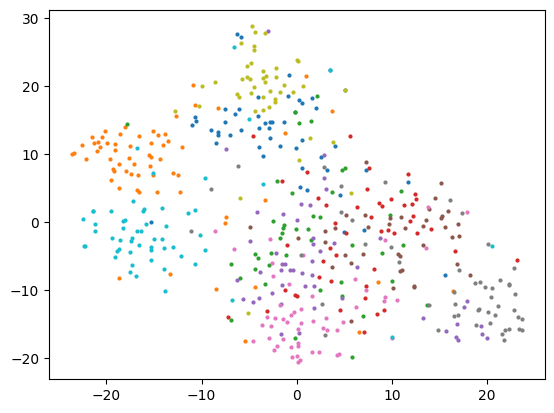

In [32]:
for i in range(10):
    mask = yt==i
    plt.scatter(X_embedded[mask][:,0], X_embedded[mask][:,1], s=4)

In [19]:
X_embedded.shape

(200, 2)

In [20]:
mask

array([False,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False,  True,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False,  True,  True, False, False, False, False, False, False,
       False,  True, False, False, False,  True, False, False, False,
       False,  True,